# Load the packages

In [34]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import spacy
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import warnings 
warnings.filterwarnings('ignore')


# Import News Text Data

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique()) #20 topics

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


In [3]:
df.head(15)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc
10000,From: a207706@moe.dseg.ti.com (Robert Loper)\n...,7,rec.autos
10001,From: kimman@magnus.acs.ohio-state.edu (Kim Ri...,6,misc.forsale
10002,From: kwilson@casbah.acns.nwu.edu (Kirtley Wil...,2,comp.os.ms-windows.misc
10003,Subject: Re: Don't more innocents die without ...,0,alt.atheism
10004,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,0,alt.atheism


# Remove emalis and newline characters

In [7]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


# Tokenize and Clean-up using gensim's simple_preprocess

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [12]:
len(data_wordsords)

11314

# Lemmatization

In [14]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
# if you get error message, try again with administrator access
nlp = spacy.load('en',disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [13]:
print(data_lemmatized[:1])

['where s  thing subject what car be nntp post host rac wam umd edu organization university maryland college park line be wonder anyone out there could enlighten car see other day be door sport car look be late early be call bricklin door be really small addition front bumper be separate rest body be know anyone can tellme model name engine spec year production where car be make history whatev info have funky look car mail thank bring  neighborhood lerxst']


# Create the Document-Word matrix

In [15]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [32]:
vectorizer.get_feature_names()[:10]

['aaa',
 'aaron',
 'abandon',
 'abbreviation',
 'abc',
 'abide',
 'ability',
 'able',
 'abolish',
 'abomination']

In [28]:
type(data_vectorized)

scipy.sparse.csr.csr_matrix

In [22]:
data_vectorized.shape

(11314, 9751)

# Check the Sparsicity

In [18]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.7758875693652992 %


In [26]:
type(data_dense)

numpy.matrixlib.defmatrix.matrix

In [20]:
data_dense.size

110322814

In [35]:
sys.getsizeof(data_vectorized) #sparse 를 위한 표현

56

In [36]:
sys.getsizeof(data_dense) #dense하게 바꾸면 저장공간 증가

136

# Build LDA model with sklearn

In [37]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


# Diagnose model performance with perplexity and log likelihood

In [38]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -9962914.762427391
Perplexity:  2057.57726202886
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# GridSearch the best LDA model

In [39]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
# GridSearchCV(cv=None, error_score='raise',
#        estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#              evaluate_every=-1, learning_decay=0.7, learning_method=None,
#              learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
#              mean_change_tol=0.001, n_components=10, n_jobs=1,
#              n_topics=None, perp_tol=0.1, random_state=None,
#              topic_word_prior=None, total_samples=1000000.0, verbose=0),
#        fit_params=None, iid=True, n_jobs=1,
#        param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#        scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# See the best topic model and its parameters

In [40]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -3421000.8022248363
Model Perplexity:  2021.9043185998346


In [41]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

# Compare LDA Model Performance Scores

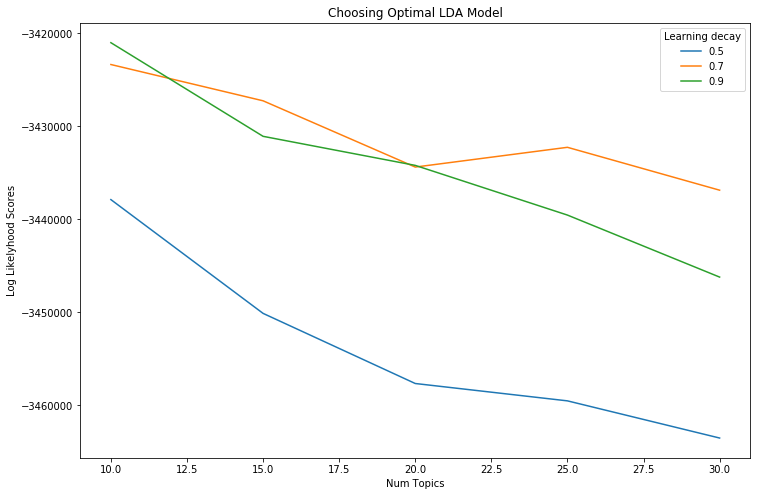

In [42]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

# See the dominant topic in each document

In [43]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0,0.98,0,0,0,0,0,4
Doc1,0,0,0,0,0.23,0.51,0.08,0.17,0,0,5
Doc2,0.36,0.23,0,0,0.18,0,0.22,0,0,0,0
Doc3,0,0.05,0,0,0.07,0.87,0,0,0,0,5
Doc4,0,0.02,0,0,0,0.95,0,0,0,0,5
Doc5,0.4,0,0,0,0.33,0,0.25,0,0.02,0,0
Doc6,0,0,0,0,0.97,0,0,0,0,0,4
Doc7,0,0,0.34,0,0.06,0.59,0,0,0,0,5
Doc8,0,0,0,0.22,0,0,0,0,0,0.77,9
Doc9,0,0,0,0,0,0,0,0,0.99,0,8


# Review topics distribution across documents

In [44]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,3141
1,0,1775
2,8,1365
3,6,1213
4,7,872
5,2,827
6,4,731
7,9,665
8,3,642
9,1,83


# Visualize the LDA model with pyLDAvis

In [45]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5       -2.180251   60.418327       1        1  18.979660
0      229.617554   13.066284       2        1  14.634460
8     -148.592300   19.603395       3        1  12.584735
3      -97.834702  159.194733       4        1  10.502443
2      -58.578194  -79.626175       5        1  10.134932
9       83.205238  -27.749136       6        1   9.795405
6       37.713493 -172.775330       7        1   9.502595
7      139.603226  112.295143       8        1   6.450028
4       43.312096  205.444595       9        1   4.640882
1      178.861008 -126.523865      10        1   2.774861, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
5343  Default   4209.000000           max   4209.000000  30.0000  30.0000
3666  Default   2654.000000           god   2654.000000  29.0000  29.0000
3534  Default   2019.000000          game   2019.000000  28.0000  28.0000
1266  Default   1850.000000           car   1850.000000  27.0000  27.0000
9569  Default   3056.000000        window   3056.000000  26.0000  26.0000
4766  Default   2205.000000           key   2205.000000  25.0000  25.0000
6166  Default  11376.000000  organization  11376.000000  24.0000  24.0000
8640  Default   1563.000000          team   1563.000000  23.0000  23.0000
5048  Default  13122.000000          line  13122.000000  22.0000  22.0000
8400  Default  12300.000000       subject  12300.000000  21.0000  21.0000
3276  Default   3071.000000          file   3071.000000  20.0000  20.0000
5921  Default   4801.000000          nntp   4801.000000  19.0000  19.0000
4078  Default   5015.000000          host   5015.000000  18.0000  18.0000
6669  Default   7190.000000          post   7190.000000  17.0000  17.0000
8135  Default   1951.000000         space   1951.000000  16.0000  16.0000
9148  Default   5634.000000    university   5634.000000  15.0000  15.0000
475   Default   1313.000000      armenian   1313.000000  14.0000  14.0000
6581  Default   1485.000000          play   1485.000000  13.0000  13.0000
3790  Default   1705.000000           gun   1705.000000  12.0000  12.0000
1467  Default   1629.000000     christian   1629.000000  11.0000  11.0000
9566  Default   1567.000000           win   1567.000000  10.0000  10.0000
6837  Default   2372.000000       program   2372.000000   9.0000   9.0000
2678  Default   2526.000000         drive   2526.000000   8.0000   8.0000
2776  Default   3330.000000           edu   3330.000000   7.0000   7.0000
6431  Default   5938.000000        people   5938.000000   6.0000   6.0000
3693  Default   1945.000000    government   1945.000000   5.0000   5.0000
6583  Default   1022.000000        player   1022.000000   4.0000   4.0000
9218  Default   8842.000000           use   8842.000000   3.0000   3.0000
498   Default   7676.000000       article   7676.000000   2.0000   2.0000
1180  Default   1353.000000           buy   1353.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
9247  Topic10     72.106761      uuencode     78.057981   3.5053  -6.2197
6216  Topic10    474.521129        output    663.343053   3.2496  -4.3355
3558  Topic10    228.077988           gay    293.709091   3.3317  -5.0681
1395  Topic10    149.521467          char    185.128420   3.3710  -5.4904
6014  Topic10     84.467711     obfuscate     96.112812   3.4554  -6.0614
8360  Topic10    158.504638        stream    208.664262   3.3096  -5.4320
458   Topic10     84.880173           arg     99.272453   3.4279  -6.0566
5395  Topic10    172.175041      medicine    246.010248   3.2277  -5.3493
2534  Topic10    232.916120       disease    366.201437   3.1321  -5.0471
5393  Topic10    238.147361       medical    410.194813   3.0408  -5.0249
1242  Topic10    120.200806        cancer    169.068780   3.2434  -5.7087
6373 

# The topic's keywords

In [46]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aaron,abandon,abbreviation,abc,abide,ability,able,abolish,abomination,...,zion,zionism,zionist,zip,zisfein,zone,zoology,zoom,zubov,zurich
Topic0,18.110664,22.171254,0.101911,0.106243,0.106540,0.188641,9.560049,179.311846,0.100784,0.101164,...,4.487398,0.102033,0.100938,2.922529,4.546627,7.374488,0.100848,6.032939,0.101117,0.100752
Topic1,0.101011,0.105275,6.603048,0.102625,0.101482,0.103003,0.119221,10.320086,0.100818,0.101924,...,0.103775,0.100953,0.100936,1.295535,0.203286,1.747076,0.100751,0.104616,0.100633,0.503095
Topic2,0.100767,4.060746,0.178792,0.105885,10.762456,43.216487,60.796846,117.599909,19.909127,0.747693,...,0.101808,0.102266,0.105098,6.761627,0.100668,1.221497,0.100637,0.101288,0.100663,4.145664
Topic3,44.990292,53.154266,10.986034,2.692139,0.101499,36.970186,107.587465,125.719308,5.826569,7.924528,...,0.101026,0.131916,0.104494,11.571373,0.100630,18.239887,0.100782,3.598051,0.100703,0.101213
Topic4,0.115813,0.104031,0.100787,0.110533,0.101135,0.102272,0.110929,0.272655,0.100704,3.675122,...,0.100954,7.822394,0.141857,0.100751,26.164041,0.100993,82.518662,0.103206,0.100711,0.100627


# Get the top 10 keywords each topic

In [47]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,just,line,write,good,subject,organization,article,know,say,think,time,make,thing,look,use
Topic 1,max,entry,output,bhj,giz,use,program,medical,homosexual,disease,number,gay,int,line,qax
Topic 2,key,use,government,chip,law,encryption,public,line,clipper,subject,organization,president,make,write,information
Topic 3,gun,people,good,think,year,make,write,right,use,say,article,time,control,base,weapon
Topic 4,car,subject,organization,line,post,article,nntp,host,university,write,new,edu,sale,buy,price
Topic 5,use,line,subject,window,organization,file,post,write,drive,problem,work,card,know,run,program
Topic 6,line,organization,subject,post,space,host,university,nntp,write,article,edu,research,center,distribution,nasa
Topic 7,game,team,play,win,line,player,subject,organization,year,hockey,season,good,university,league,post
Topic 8,god,say,write,christian,subject,think,people,line,believe,know,organization,article,make,question,just
Topic 9,people,say,armenian,state,war,write,right,turkish,kill,israeli,government,israel,article,know,subject


# Predict the topics for a new piece of text

In [48]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['god', 'say', 'write', 'christian', 'subject', 'think', 'people', 'line', 'believe', 'know', 'organization', 'article', 'make', 'question', 'just']


# Cluster documents that share simiar topics and plot

In [49]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Percentage of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))


Component's weights: 
 [[ 0.19  0.03  0.07  0.07  0.12  0.94  0.19  0.06  0.09  0.04]
 [ 0.67  0.03  0.16  0.2   0.17 -0.31  0.34  0.17  0.44  0.16]]
Percentage of Variance Explained: 
 [0.2  0.15]


Text(0.5,1,'Segregation of Topic Clusters')

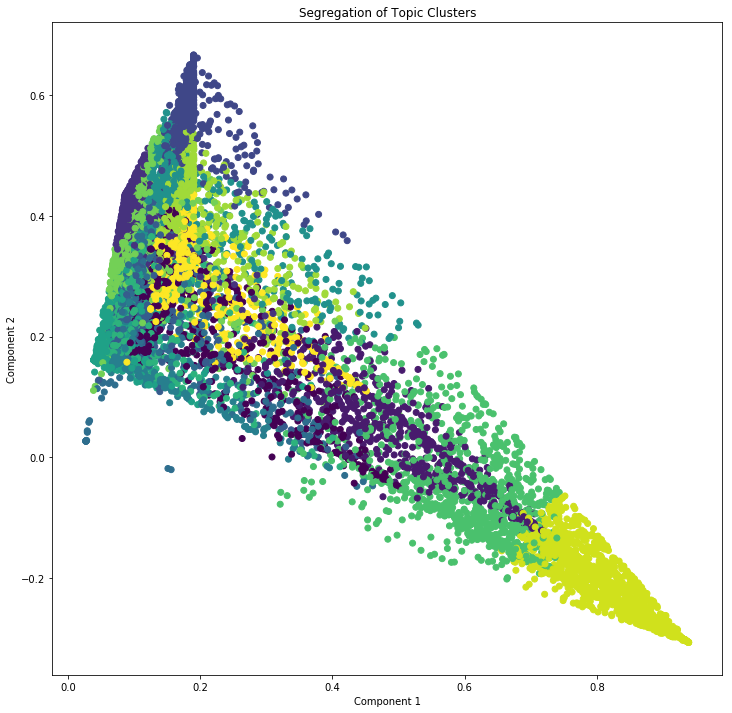

In [50]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("Segregation of Topic Clusters", )

# Get similar documents for any given piece of text

In [51]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [52]:
# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:1000])

Topic KeyWords:  ['god', 'say', 'write', 'christian', 'subject', 'think', 'people', 'line', 'believe', 'know', 'organization', 'article', 'make', 'question', 'just']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.  0.  0.  0.  0.8 0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.1 0.  0.  0.  0.  0.  0.8 0. ]]

 From: (James Owens) Subject: Re: Question for those with popular morality Organization: National Capital Freenet, Ottawa, Canada Lines: 87 In article 70257, (David Bold) writes: >In article >(James Owens) writes: >>You seem to be saying that, God being unknowable, His morality >>is unknowable. >Yep, thats pretty much it. . . . >. . . >As I understand it, the Sadducees believed that the Torah was all >that was required, whereas the Pharisees (the ancestors of modern >Judaism) believed that the Torah was available for interpretation >to lead to an understanding of the required Morality in all its >nuances (->Talmud). >The essence of all of this is that Biblical Morality is an >inte